## Visualize probability line plots and cumulative bar plots

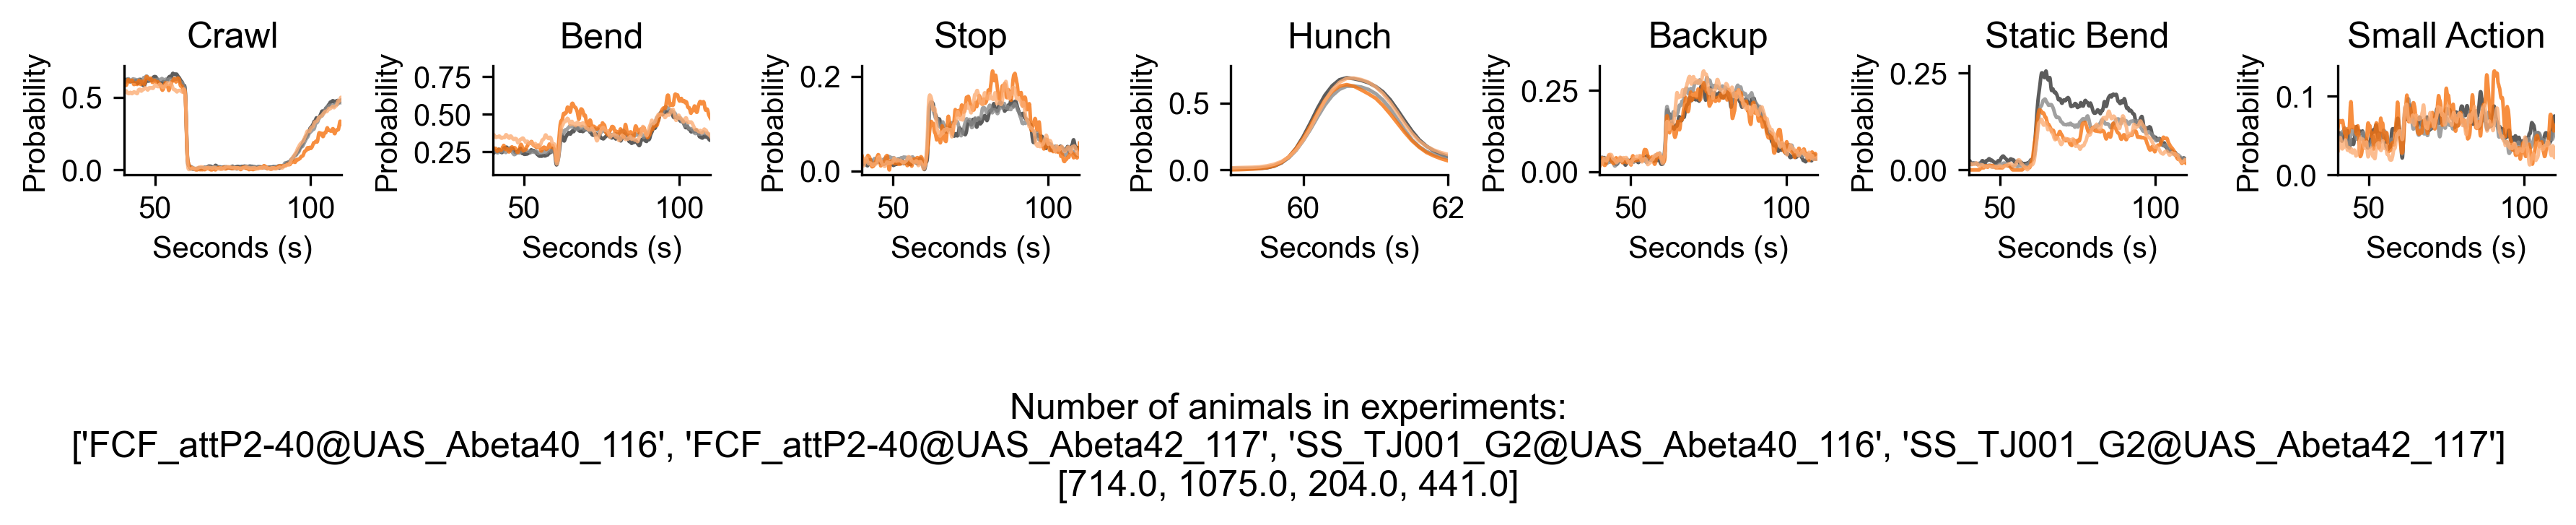

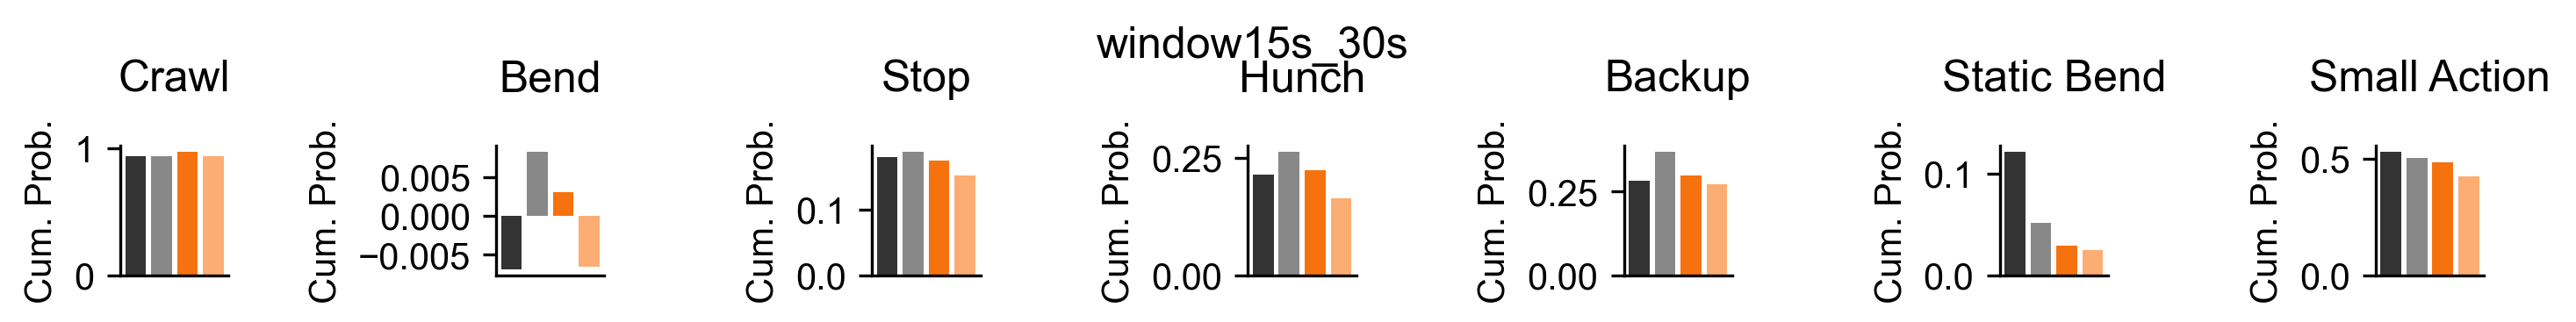

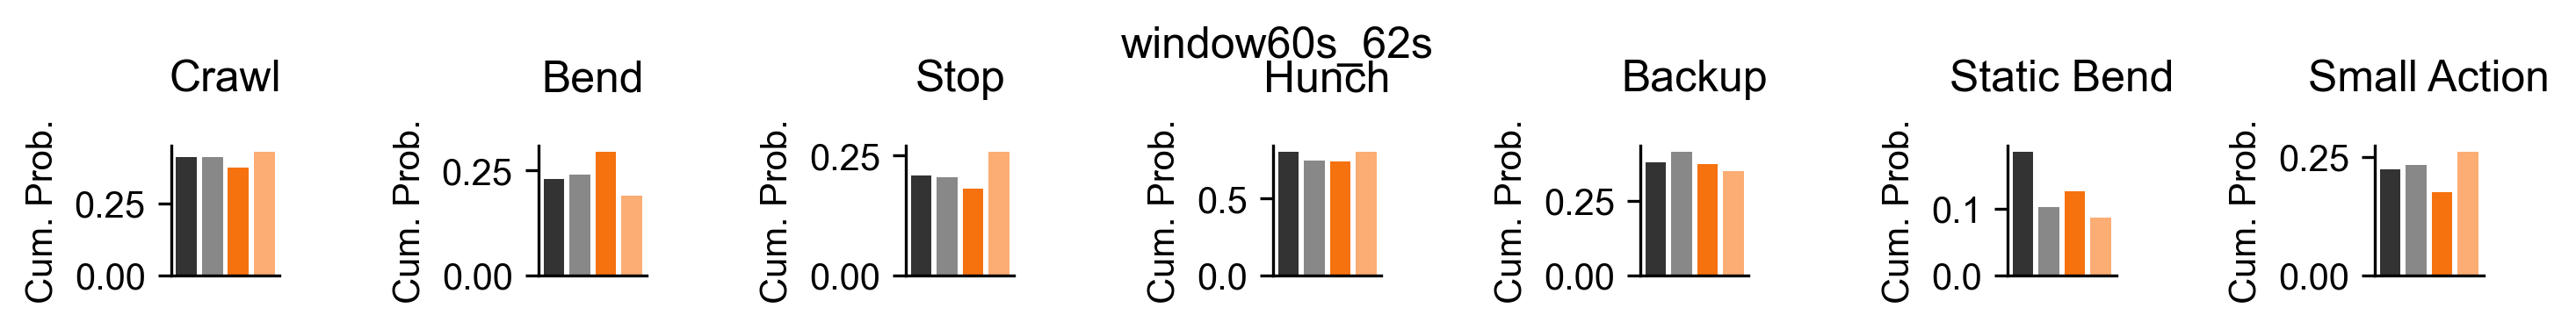

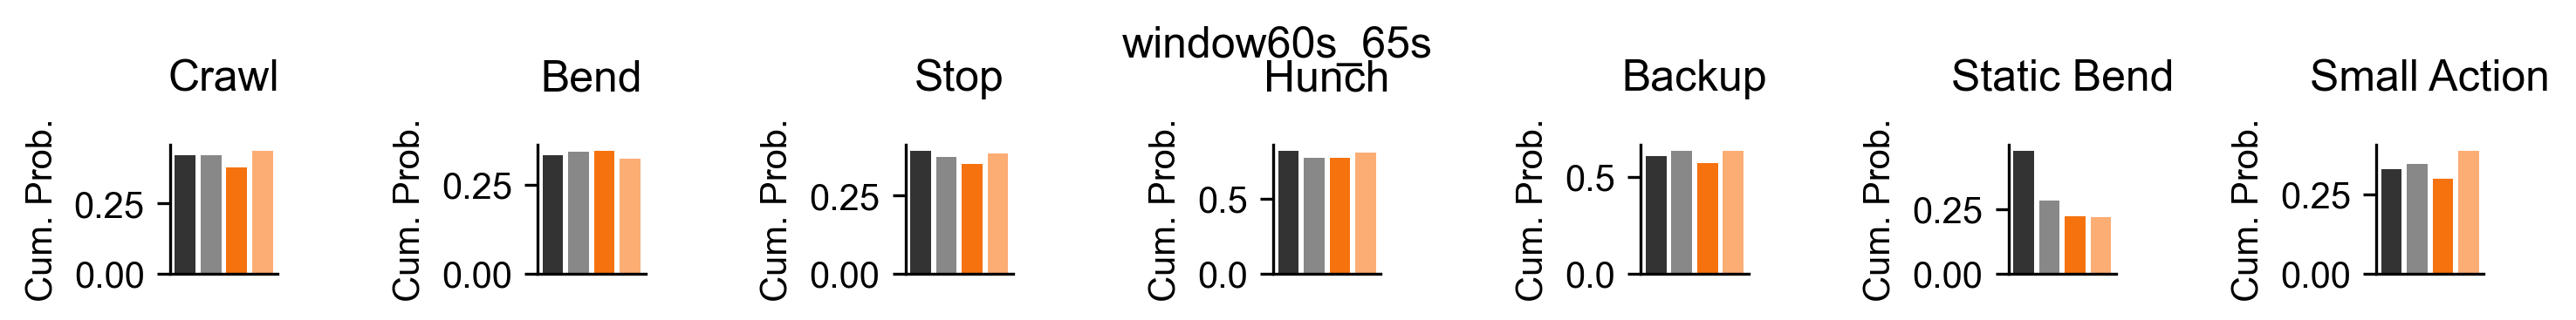

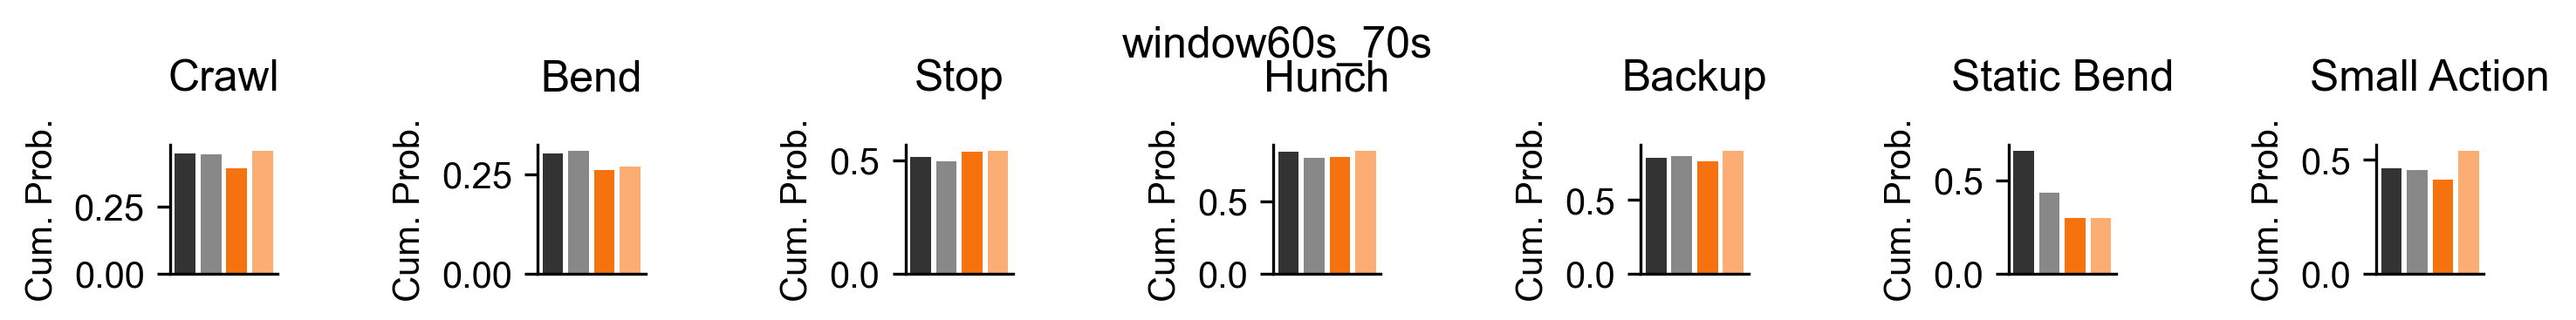

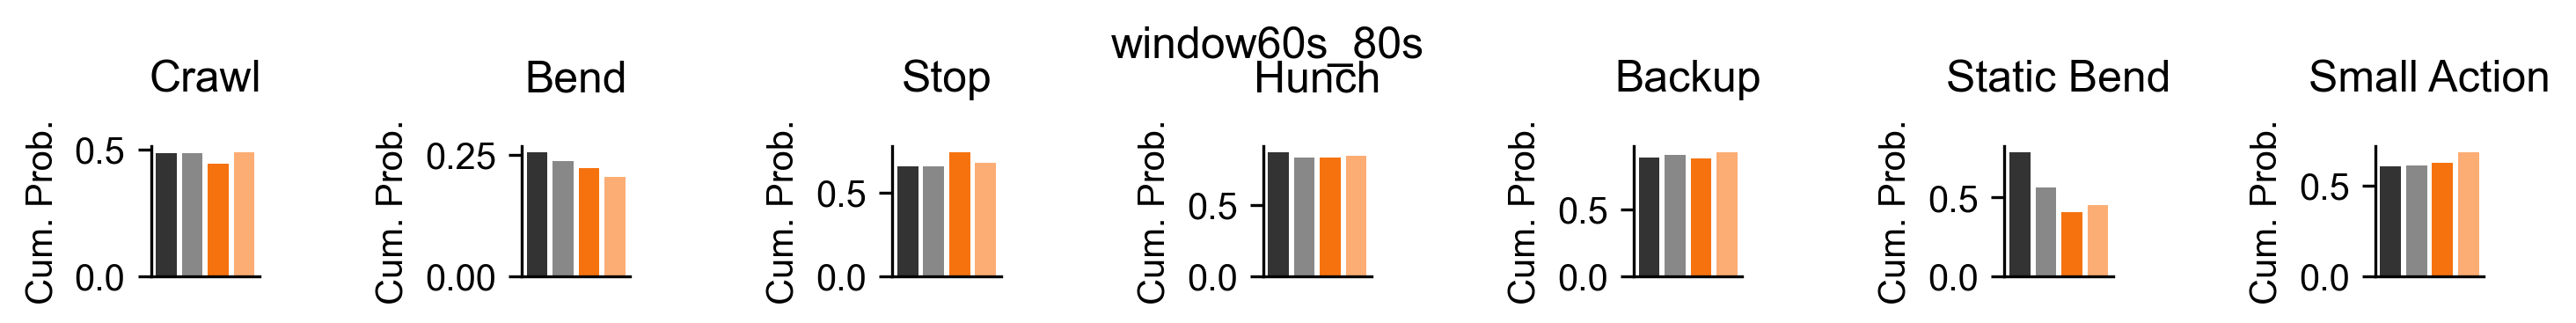

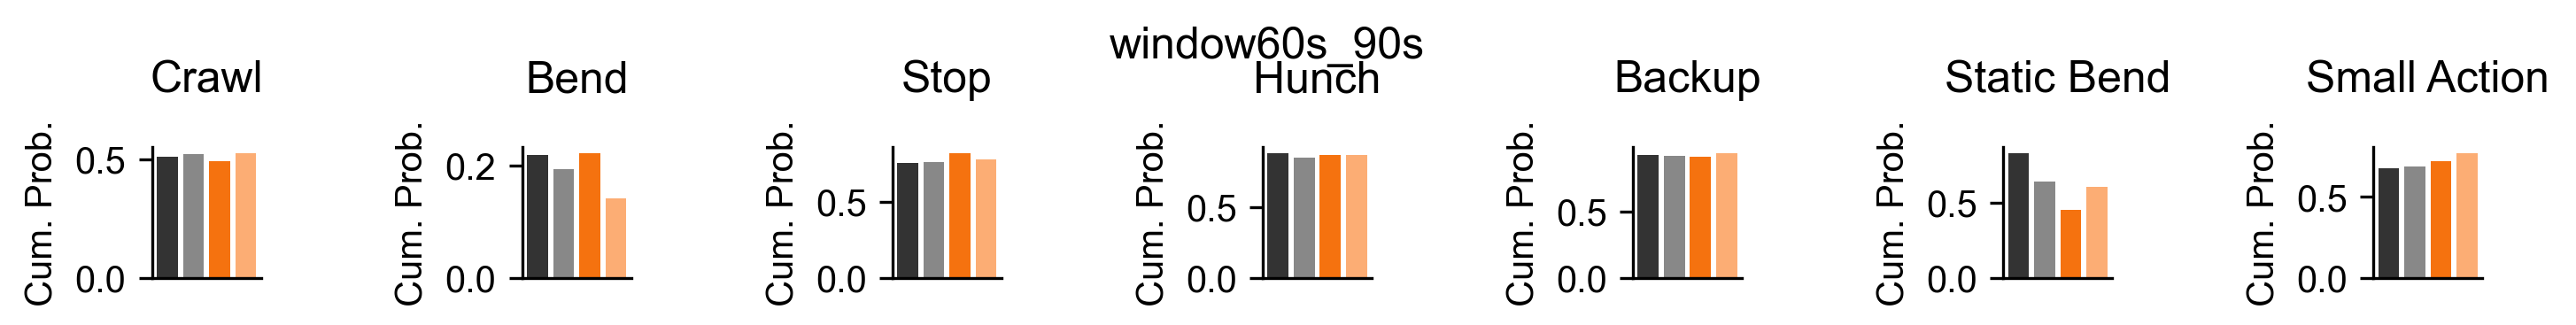

In [6]:
import behavior

# instantiate a list of genotypes to process trx and features to extract
genotypes = [
    #'FCF_attP2@UAS_Abeta40_116',
    #'FCF_attP2@UAS_Abeta42_117',
    'FCF_attP2-40@UAS_Abeta40_116',
    'FCF_attP2-40@UAS_Abeta42_117',
    #'GMR_61D08@UAS_Abeta40_116',
    #'GMR_61D08@UAS_Abeta42_117',
    #'GMR_20B01@UAS_Abeta40_116',
    #'GMR_20B01@UAS_Abeta42_117',
    #'GMR_55C05@UAS_Abeta40_116',
    #'GMR_55C05@UAS_Abeta42_117',
    #'GMR_SS00739@UAS_Abeta40_116',
    #'GMR_SS00739@UAS_Abeta42_117',
    #'GMR_SS00888@UAS_Abeta40_116',
    #'GMR_SS00888@UAS_Abeta42_117',
    #'GMR_SS00918@UAS_Abeta40_116',
    #'GMR_SS00918@UAS_Abeta42_117',
    'SS_TJ001_G2@UAS_Abeta40_116',
    'SS_TJ001_G2@UAS_Abeta42_117',
]


#colors = ['#333333','#888888','#1e8f33','#4ecc65'] # Ch green
#colors = ['#333333','#888888','#0385ff','#8bcdfc'] # B1 blue
#colors = ['#333333','#888888','#1100ff','#858dff'] #B2 blue
#colors = ['#333333','#888888','#f2027a','#fc9ad7'] # Hb pink
colors = ['#333333','#888888','#f5720f','#fcad74'] # LNa orange

input = '/Volumes/TOSHIBA/t2'
root = 'dataFiles_larvatagger_v8_bendSeparated' 
output = '/Volumes/TOSHIBA/t2_behavior_data_abalysis' + '/python_plots/larvatagger_v8_bendSeparated'
protocol = 'p_4_60s1x30s0s#p_4_120s10x2s8s#n#n'
neuron = genotypes[2].split('@')[0]

behavior.visualize(input,protocol,root,genotypes,output,neuron,colors,True)

## Visualize cast probability--mean and CDF

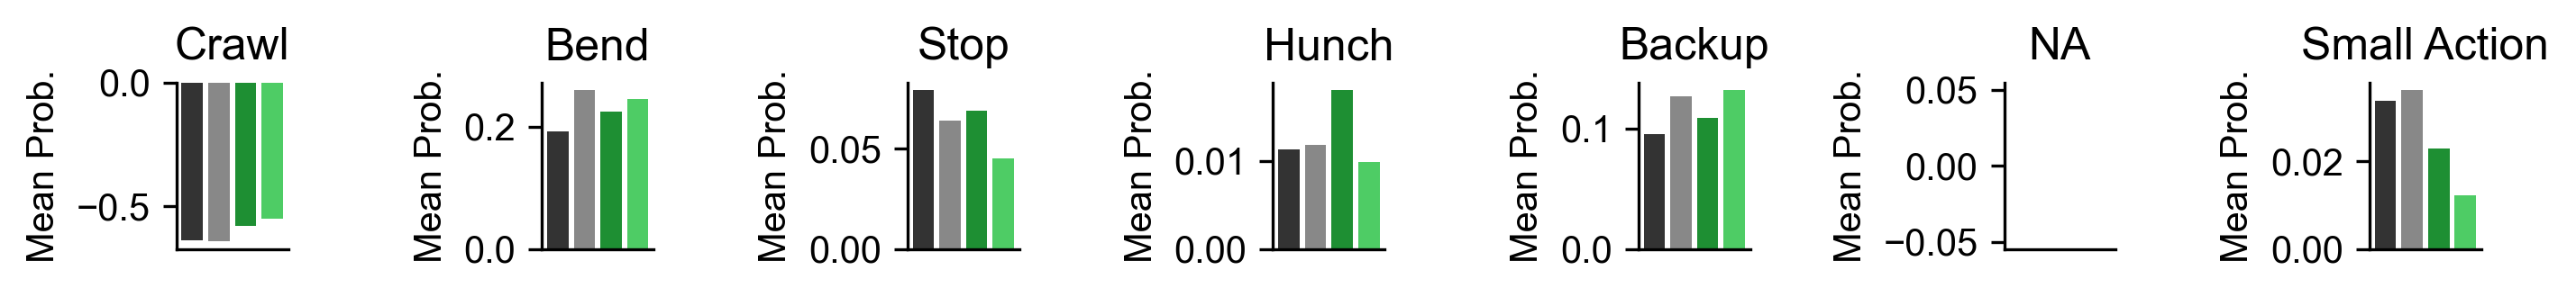

In [3]:
lenWindows = [5,]
stimulus_start = 62
nSim = 1000

input = '/Volumes/TOSHIBA/t2'
root = 'dataFiles_larvatagger_v8_bendSeparated' 
output = '/Volumes/TOSHIBA/t2_behavior_data_abalysis' + '/python_plots/larvatagger_v8_bendSeparated/mean_prob'
protocol = 'p_4_60s1x30s0s#p_4_120s10x2s8s#n#n'
neuron = genotypes[2].split('@')[0]

for lenWindow in lenWindows:
    import behavior
    import scipy.io
    import numpy as np
    import scipy.signal
    import os
    from itertools import combinations
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    import pandas as pd

    plt.rcParams['font.sans-serif'] = "Arial"
    # Then, "ALWAYS use sans-serif fonts"
    plt.rcParams['font.family'] = "sans-serif"

    actions = [
        'run',
        'cast',
        'stop',
        'hunch',
        'backup',
        'bend_static',
        'small_actions',
    ]

    genotypes_to_plot = []
    t = []
    n_larvae = []

    for genotype in genotypes:

        file = "{}/{}/{}/{}/probabilitiesovertime.mat".format(input,genotype,protocol,root)
        prob = scipy.io.loadmat(file,squeeze_me = True)
        prob = prob['probabilities']
        actions_to_plot = []

        for a,action in enumerate(actions):
            #if action == 'cast':
            #    data = prob[action].item()+prob['roll'].item()
            #else:
            data = prob[action].item()
            data = np.transpose(data)
            t = data[0]
            n = max(data[2])
            probability = data[1]
            actions_to_plot.append(probability)
        
        actions_to_plot = np.array(actions_to_plot)
        probabilities = pd.DataFrame(data = np.transpose(actions_to_plot),index=t,columns=actions)
        #probabilities.to_csv('{}/{}_probabilitiesTimeSeries.csv'.format(output_line_plots,genotypes))
        genotypes_to_plot.append(actions_to_plot)
        n_larvae.append(n)

    genotypes_to_plot = np.array(genotypes_to_plot)
    def find_nearest(array, value):
        import numpy as np
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx

    action_names_plot = ['Crawl','Bend','Stop','Hunch','Backup','NA','Small Action']
    fig,axs = plt.subplots(1,len(actions), figsize=(10,1.2), dpi=300)
    axs = axs.flatten()
    combos = list(combinations(range(len(genotypes)), 2))

    from scipy.integrate import simpson
    for i,action in enumerate(actions):

        data=[]
        probs_baseline=[]
        probs_after=[]
        freq_baseline = []
        freq_after = []

        for j,__ in enumerate(genotypes):
            
            prob_after = np.mean(genotypes_to_plot[j][i][find_nearest(t,stimulus_start):find_nearest(t,stimulus_start+lenWindow)])
            probs_after.append(prob_after)
            freq_after.append(prob_after*n_larvae[j])

            prob_baseline = np.mean(genotypes_to_plot[j][i][find_nearest(t,10):find_nearest(t,40)])
            freq_baseline.append(prob_baseline*n_larvae[j])

            norm_prob = (prob_after-prob_baseline)
            data.append(norm_prob)
                    
        axs[i].bar(np.arange(len(genotypes)),data,color=colors)
        axs[i].set_title(action_names_plot[i],pad=15)
        axs[i].set_ylabel('Mean Prob.')
        #axs[i].set_ylim([0,0.2])

        x_left, x_right = axs[i].get_xlim()
        y_low, y_high = axs[i].get_ylim()       
        axs[i].set_aspect(abs((x_right-x_left)/(y_low-y_high))*1.5)
        axs[i].spines.right.set_visible(False)
        axs[i].spines.top.set_visible(False)
        axs[i].xaxis.set_tick_params(labelbottom=False, bottom=False)

        plt.tight_layout()
        
        plt.savefig('{}/{}/meanProb_{}s.svg'.format(output,neuron,lenWindow), format='svg',bbox_inches="tight")
        plt.savefig('{}/{}/meanProb_{}s.eps'.format(output,neuron,lenWindow), format='eps',bbox_inches='tight')

        if action == 'cast':
            ## first try sampling hypergeometric 
            result=[]
            for i,__ in enumerate(combos):
                group1 = combos[i][0]
                group2 = combos[i][1]

                observation = np.array([
                    [freq_baseline[group1],freq_after[group1]],
                    [freq_baseline[group2],freq_after[group2]]
                ])
                total = np.array([
                    [n_larvae[group1], n_larvae[group1]],
                    [n_larvae[group2], n_larvae[group2]]
                ])
                try:
                    p = behavior.hypergeom(observation,total,nSim)
                    result.append([genotypes[group1],genotypes[group2],'NA',p,p*len(combos)])
                except:
                    result.append(['NA','NA','NA','NA','NA'])
            # Not sure if you want to increase counti here
            # if so add the line here
                    continue 

            with open('{}/{}/bootstrap_{}s.txt'.format(output,neuron,lenWindow), 'w') as fp:
                for item in result:
                    # write each item on a new line
                    fp.write('%s\n' % ['group1','group2','statistic','pvalue','padjusted'])
                    fp.write('%s\n' % item)
            
            #chi-square on normalized probability
            result=[]

            for i,__ in enumerate(combos):
                group1 = combos[i][0]
                group2 = combos[i][1]

                observation = np.array([
                    [data[group1]*n_larvae[group1],data[group2]*n_larvae[group2]],
                    [n_larvae[group1],n_larvae[group2]]
                ])
                try:
                    test = stats.chi2_contingency(observation)
                    statistic = test[0]
                    pvalue = test[1]
                    padj = pvalue*len(combos)
                    if action== 'cast':
                        result.append([genotypes[group1],genotypes[group2],'NA',pvalue,padj])
                    else:
                        result.append([genotypes[group1],genotypes[group2],statistic,pvalue,padj])
                except:
                    result.append(['NA','NA','NA','NA','NA'])
            # Not sure if you want to increase counti here
            # if so add the line here
                    continue 

            with open('{}/{}/chisquare_{}s.txt'.format(output,neuron,lenWindow), 'w') as fp:
                for item in result:
                    # write each item on a new line
                    fp.write('%s\n' % ['group1','group2','statistic','pvalue','padjusted'])
                    fp.write('%s\n' % item)


In [16]:
# test that the statistical method work
# this observation matrix for sure will produce SIGNFIICANT pvalue
p = behavior.hypergeom(np.array([[90.58,111.3],[80.82,124.2]]),np.array([[200,200],[200,200]]),100000)
# indeed p values is 0
p

0.15062

## Ethogram

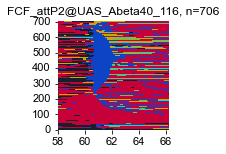

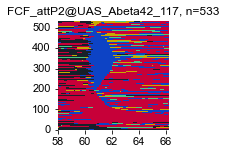

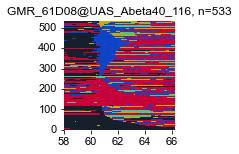

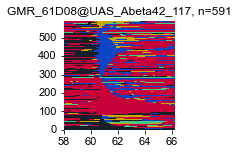

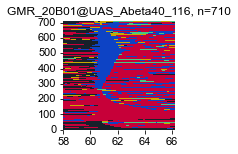

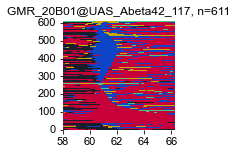

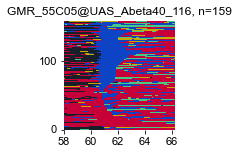

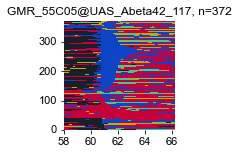

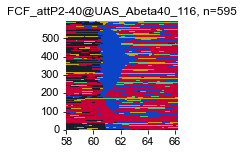

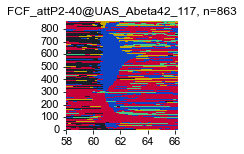

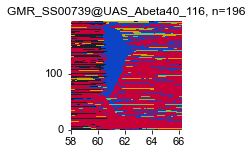

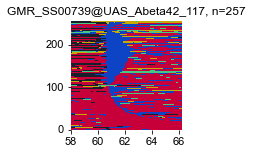

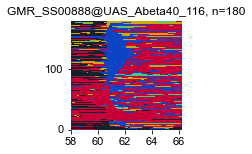

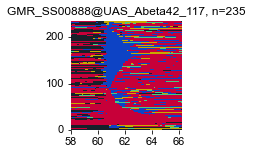

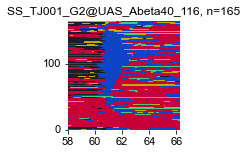

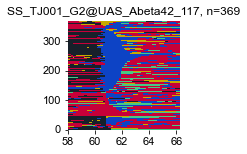

In [3]:
genotypes = [
    'FCF_attP2@UAS_Abeta40_116',
    'FCF_attP2@UAS_Abeta42_117',
    'GMR_61D08@UAS_Abeta40_116',
    'GMR_61D08@UAS_Abeta42_117',
    'GMR_20B01@UAS_Abeta40_116',
    'GMR_20B01@UAS_Abeta42_117',
    'GMR_55C05@UAS_Abeta40_116',
    'GMR_55C05@UAS_Abeta42_117',
    'FCF_attP2-40@UAS_Abeta40_116',
    'FCF_attP2-40@UAS_Abeta42_117',
    'GMR_SS00739@UAS_Abeta40_116',
    'GMR_SS00739@UAS_Abeta42_117',
    'GMR_SS00888@UAS_Abeta40_116',
    'GMR_SS00888@UAS_Abeta42_117',
    'SS_TJ001_G2@UAS_Abeta40_116',
    'SS_TJ001_G2@UAS_Abeta42_117',
    #'GMR_SS00918@UAS_Abeta40_116',
    #'GMR_SS00918@UAS_Abeta42_117',
]
input = '/Volumes/TOSHIBA/t2'
root = 'dataFiles_larvatagger_v8' 
output = '/Volumes/TOSHIBA/t2_behavior_data_abalysis' + '/larvatagger_v8_bendSeparated'
protocol = 'p_4_60s1x30s0s#p_4_120s10x2s8s#n#n'
neuron = genotypes[2].split('@')[0]

import behavior
behavior.ethogram(input,root,genotypes,protocol,output)

## Action duration computation

Writing Kruskal-Wallis H-test and post-hoc Dunn test results...


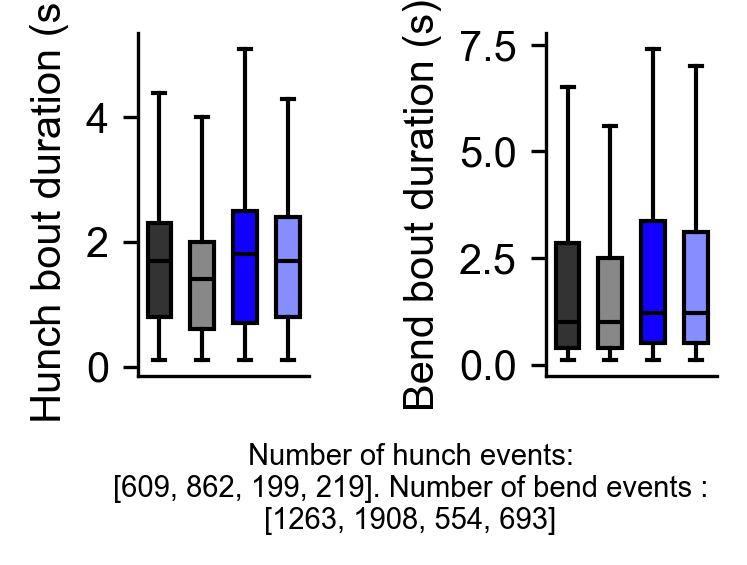

In [2]:
genotypes = [
    #'FCF_attP2@UAS_Abeta40_116',
    #'FCF_attP2@UAS_Abeta42_117',
    'FCF_attP2-40@UAS_Abeta40_116',
    'FCF_attP2-40@UAS_Abeta42_117',
    #'GMR_61D08@UAS_Abeta40_116',
    #'GMR_61D08@UAS_Abeta42_117',
    #'GMR_20B01@UAS_Abeta40_116',
    #'GMR_20B01@UAS_Abeta42_117',
    #'GMR_55C05@UAS_Abeta40_116',
    #'GMR_55C05@UAS_Abeta42_117',
    'GMR_SS00739@UAS_Abeta40_116',
    'GMR_SS00739@UAS_Abeta42_117',
    #'GMR_SS00888@UAS_Abeta40_116',
    #'GMR_SS00888@UAS_Abeta42_117',
    #'SS_TJ001_G2@UAS_Abeta40_116',
    #'SS_TJ001_G2@UAS_Abeta42_117',
    #'GMR_SS00918@UAS_Abeta40_116',
    #'GMR_SS00918@UAS_Abeta42_117',
]

#colors = ['#333333','#888888','#1e8f33','#4ecc65'] # Cho green
#colors = ['#333333','#888888','#0385ff','#a2dafc'] # B1 blue
colors = ['#333333','#888888','#1100ff','#858dff'] #B2 blue
#colors = ['#333333','#888888','#f2027a','#fc9ad7'] # Hb pink
#colors = ['#333333','#888888','#f5720f','#fcad74'] # LNa orange

input = '/Volumes/TOSHIBA/t2'
root = 'dataFiles_larvatagger_v8' 
output = '/Volumes/TOSHIBA/t2_behavior_data_abalysis/python_plots' + '/larvatagger_v8_bendNotSeparated'
protocol = 'p_4_60s1x30s0s#p_4_120s10x2s8s#n#n'
neuron = genotypes[2].split('@')[0]

import behavior
behavior.duration(input,root,protocol,output,genotypes,neuron,colors,'kruskaldunn')

## Check classifications from trx

In [4]:
import numpy as np
import pandas as pd
import scipy.io

path_originalTable = "/Volumes/TOSHIBA/alzheimer_data_tag_attP2_TEST.xlsx"
path_save = "/Volumes/TOSHIBA/alzheimer_data_tag_attP2_threshold_validation.xlsx"

dictionary_actions = {
    "run":1,
    "cast":2,
    "stop":3,
    "hunch":4,
    "back":5,
    "small_actions":7,
    "static_bend":6
    }

action_names = {
    1:"run",
    2:"cast",
    3:"stop",
    4:"hunch",
    5:"back",
    7:"small_actions",
    6:"static_bend"
    }
                       
def most_frequent(List):
    List = List.tolist()
    counter = 0
    num = List[0]
     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num

def find_nearest(array, value):     
    array = np.asarray(array)    
    idx = (np.abs(array - value)).argmin()     
    return idx

names_actions = ["hunch","cast","back","small_actions","stop","run","static_bend"]
test=pd.read_excel(path_originalTable, decimal='.')
#test['temps début'] = pd.to_numeric(test['temps début'], errors='coerce')
#test['temps fin'] = pd.to_numeric(test['temps fin'], errors='coerce')
#test =  test.dropna(subset=['temps début', 'temps fin', 'larva'])

classfications = []
classfications_TF = []

for i in range(len(test)):
    # for every single event listed in the test data
    event = test.iloc[i]

    # find the right concatenated trx file of that genotype
    file = '/Volumes/TOSHIBA/trx_concatenated/{}/trx_concatenated.mat'.format(event['genotype'])

    # extract relevant data
    data = scipy.io.loadmat(file,squeeze_me = True)
    experiment = data['TRX']['id'] # experimental timestamp
    larva = data['TRX']['numero_larva_num'] # larva_id
    t = data['TRX']['t']
    classification = data['TRX']['global_state_large_state']
    # let's save some memory
    del data 

    # find the larva
    exp = np.array([True if item == event['experiment'] else False for item in experiment.tolist()], dtype=bool)
    id = np.array([True if item == event['larva'] else False for item in larva.tolist()], dtype=bool)
    # where the experiment and larval id booleans intersect, that is the index for that exact larva
    index = np.logical_and(exp,id)

    # find the isolated events for that larva
    try:
        t_start = find_nearest(t[np.where(index==True)][0],event['temps début'])
        t_end = find_nearest(t[np.where(index==True)][0],event['temps fin'])
        # then find the classification result
        event_class = classification[np.where(index==True)][0][t_start:t_end]
        # make the most frequently appearing integer (action) the classified action
        if event_class.size>0:
            #event_class = most_frequent(event_class)
            # append the classification results
            #classfications.append(action_names[event_class])
            # append whether classification is true or false
            #classfications_TF.append(dictionary_actions[event['real action']]==event_class)
            classfications_TF.append(dictionary_actions[event['real action']] in event_class)
            if dictionary_actions[event['real action']] in event_class:
                classfications.append(event['real action'])
            else:
                classfications.append(action_names[most_frequent(event_class)])
        else:
            classfications.append(np.nan)
            # append whether classification is true or false
            classfications_TF.append(np.nan)
    except:
        # if somehow the event is not found in the corresponding trx file, then
        print(r'failed to find event #{}'.format(i))
        classfications.append(np.nan)
            # append whether classification is true or false
        classfications_TF.append(np.nan)
        continue
    
# convert classification T/F result into integer
classfications_TF = np.array(classfications_TF,dtype=bool)*1
# replace it in the dataframe
test['false(0)/True(1)'] = classfications_TF
test['classification'] = classfications

# save the new dataframe
test.to_excel(path_save,index=False)

failed to find event #166
failed to find event #199
